---
title: Implementing Newton's Optimizer
author: Sophie Seiple
date: '2024-05-1'
image: "newton.jpeg"
description: "Implementing and testing the newton's optimizer method for logistic regression."
format: html
---

First I read in my logistic regression with newton's optimizer [.py file](https://github.com/esseiple/esseiple.github.io/blob/main/posts/newtons/newton.py).

In [55]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, NewtonOptimizer, GradientDescentOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Abstract
In this blog post, I implement Newton's Method for Logistic Regression, building on my previous implementation of logistic regression. Newton's Method, a second-order optimization technique, requires knowledge of both the first and second derivatives of the loss function. I first implementation a NewtonOptimizer class, extending my logistic regression model with a new method to compute the Hessian matrix and perform the optimization step for logistic regression using this new factor. Through experiments and visualizations, I explore the effectiveness of Newton's method in converging to the correct solution and its potential for faster convergence compared to standard gradient descent under certain conditions. Additionally, I calculate the computational costs associated with Newton's method and gradient descent, providing insights into the trade-offs between the two methods.

## B. Experiments

### 1. Testing Convergence Behavior of Newtown Optimizer

I used the classification data generation function from the logistic and perceptron blog posts to create linearly seperable data.

In [56]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

After generating my data, I plotted it to show what the class seperation looks like. Again, this code is taken from the logistic regression and perceptron blog posts.

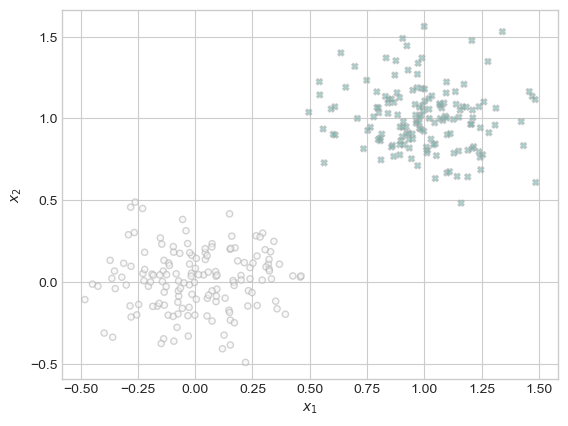

<Figure size 1000x600 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# adapted from logistic & perceptron blog post
def plot_classification_data(X, y, ax):
    plt.figure(figsize=(10, 6))
    targets = [0, 1]
    markers = ["o" , "X"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
    
fig, ax = plt.subplots(1, 1)

# create and plot data
X, y = classification_data(noise = 0.2)
plot_classification_data(X, y, ax)

We can see the data is clearly linearly seperable. Next, I defined a few functions, again from the previous blog posts, to help me visualize the progress of me model through its optimization steps

In [58]:
# helpful functions from previous blog posts

# draws found seperating line on graph
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# finds final model accuracy on data
def find_accuracy(X, y):
    predictions = LR.predict(X)
    correct_preds = (predictions == y).float()
    accuracy = torch.mean(correct_preds)

    print(f"Accuracy: {accuracy.item()}")

# plots the generated loss vectors
def plot_loss(lvec):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(lvec, color = "slategrey")
    plt.scatter(torch.arange(len(lvec)), lvec, color = "slategrey", s=5)
    plt.gca().set(xlabel = "Logistic Regression Steps", ylabel = "Loss")
    
    plt.title(f"Final loss: {lvec[len(lvec)-1]:.3f}")

First, I wanted to observe whether my model implemented with the newton optimizer would converge regularly on seperable data.

Accuracy: 1.0


[(-1.0, 2.0), (-1.0, 2.0)]

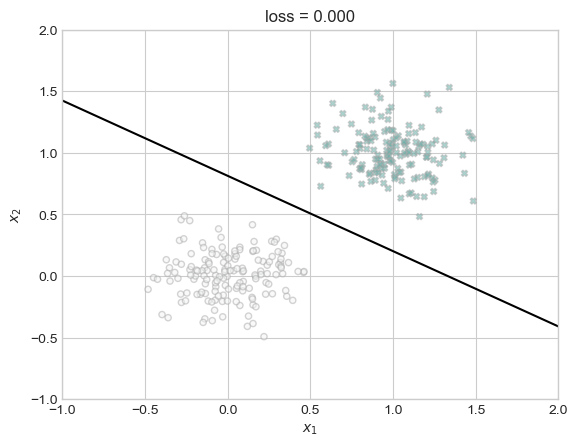

<Figure size 1000x600 with 0 Axes>

In [59]:
# instantiate a model
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

# instantiate a loss vector
loss_vec = []

# for 6000 iterations, track the progress of the loss of our model
for index in range(6000):
    
    opt.step(X, y, a = 0.5)
    
    loss = LR.loss(X, y).item()
    loss_vec.append(loss)

# find our final accuracy
find_accuracy(X, y)

# plot the final classification line against our data

fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2))

From this we see that our model does in fact converge to the correct seperating line for our data, and ends with a loss of 0.00 and an accuracy of 100%.

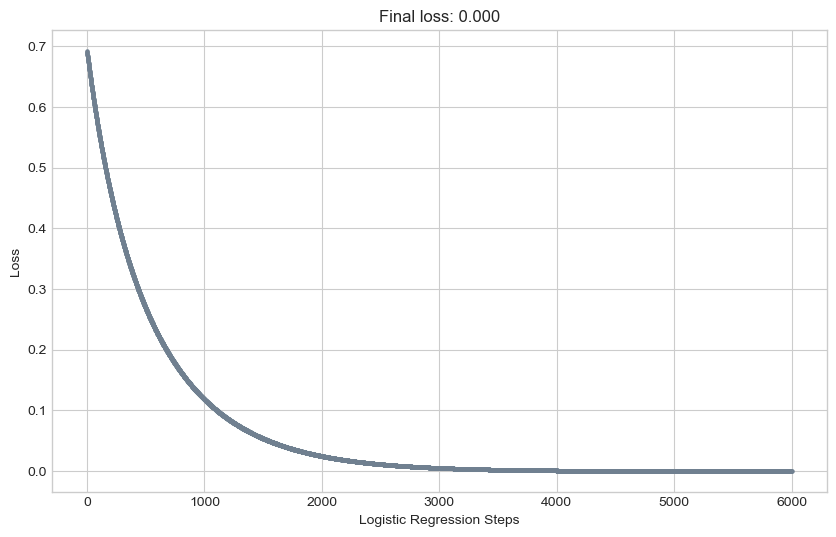

In [61]:
plot_loss(loss_vec)

Again, here we can see our loss converging to zero as expected across our 6000 iterations.

### 2. Comparing Newtown's Optimizer to Standard Gradient Descent

In order to compare the performance of my Newtown's optimizer implementation to my previously implemented standard gradient descent optimizer, I ran both optimizers for 8000 iterations, tracking the loss at each step, and then graphed them side-by-side to observe the difference. My goal was to observe that in at least some cases Newtown's optimizer converges faster than gradient descent.

Final Loss (Newton's Method): 0.0
Final Loss (Gradient Descent): tensor(0.0081)


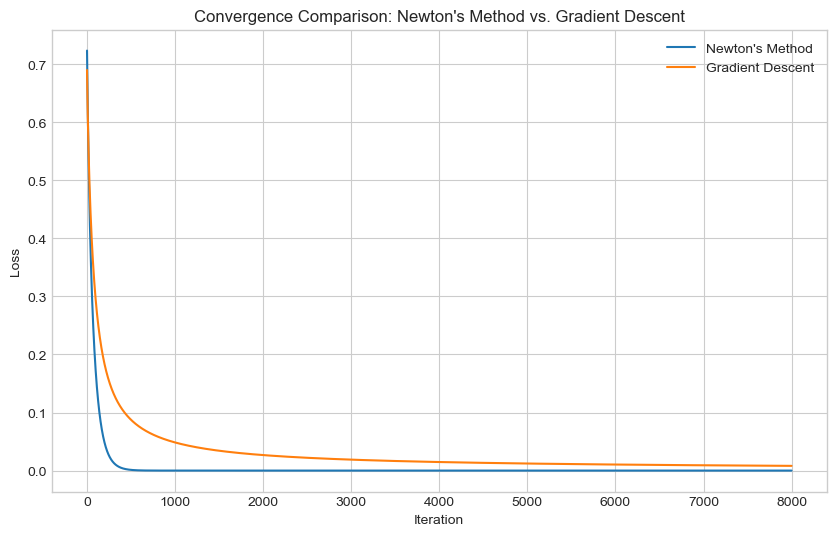

In [63]:
# Initialize logistic regression model and Newton optimizer
LR = LogisticRegression()

opt_newton = NewtonOptimizer(LR)
opt_gradient_descent = GradientDescentOptimizer(LR)

# Lists to store losses for each iteration
loss_vec_newton = []
loss_vec_gradient_descent = []
loss_gradient_descent = float('inf')
loss_newton = float('inf')

# Run Newton's method for 8000 iterations
for _ in range(8000):
    loss_newton = LR.loss(X, y).item()
    opt_newton.step(X, y, a=4)
    loss_vec_newton.append(loss_newton)

# Re-initialize weights for gradient descent
LR.w = None
LR.pastw = None

# Run standard gradient descent for 8000 iterations
for _ in range(8000):
    loss_gradient_descent = opt_gradient_descent.step(X, y, a=0.1, b=0)
    loss_vec_gradient_descent.append(loss_gradient_descent)

# Print final loss values
print("Final Loss (Newton's Method):", loss_newton)
print("Final Loss (Gradient Descent):", loss_gradient_descent)

# Plot the convergence of both methods
plt.figure(figsize=(10, 6))
plt.plot(loss_vec_newton, label="Newton's Method")
plt.plot(loss_vec_gradient_descent, label="Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence Comparison: Newton's Method vs. Gradient Descent")
plt.legend()
plt.grid(True)
plt.show()


From this graph we see that Newtown's optimizer does in fact converge faster than gradient descent with these respective alphas on this linearly seperable data.

### 3. When Alpha Is Too Large, Newtown's Should Not Converge 

In order to test this, I ran my loss vector creation loop over a small number of iterations for a very large alpha (745). At very large numbers I had an error, but still being able to graph the vector we can see it's trend towards non-convergence.

In [ ]:
X, y = classification_data(n_points=300, noise = 0.5)

# Initialize logistic regression model and Newton optimizer
LR = LogisticRegression()
opt_newton = NewtonOptimizer(LR)

# Lists to store losses for each iteration
loss_vec_newton = []

# Run Newton's method for 10 iterations
for _ in range(10):
    loss_newton = LR.loss(X, y).item()
    opt_newton.step(X, y, a=745)
    loss_vec_newton.append(loss_newton)


Final Loss (Newton's Method): 8.40453815460205


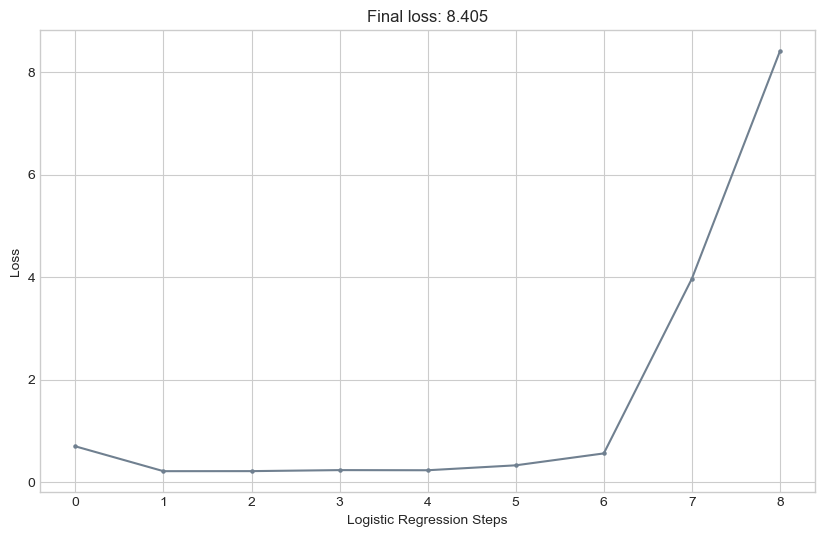

In [80]:
# Print final loss values
print("Final Loss (Newton's Method):", loss_vec_newton[-1])

plot_loss(loss_vec_newton)

From this we can see that our model is not starting to converge in the way we saw it do with smaller alpha values.

## C. Operation Counting

Working with the following assumptions on computing costs:

Loss, $L$ = $c$

Gradient, $G$ = $2c$

Hessian, $H$ = $pc$

Inverting a $p\times p$ matrix = $k_1p^\gamma$

Multiplying by $H$ = $k_2p^{2}$


Finding the total computational costs of Newtown's method.

Assuming: Newtown's method converges to an adequate solution in $t_\mathrm{nm}$ steps.

$1.$ First, we calculate the computing cost of a single step:<br>
   - Computing $L$ = $c$
   - For as many steps as it takes to converge, i.e. $t_\mathrm{nm}$ steps
      - Computing $G$ = $2c$
      - Computing $H$ = $pc$
      - Inverting hessian matrix = $k_1p^\gamma$
      - Multiplying by $H$ = $k_2p^{2}$

$2.$ Adding up all of the steps together, we get the total computational cost for our Newtown's optimizer, which is:<br>
- $O(c + t_\mathrm{nm} \times (2c + pc + k_1p^\gamma + k_2p^{2}))$

Finding the total computational costs of standard gradient descent.

Assuming: standard gradient descent converges to an adequate solution in $t_\mathrm{gd}$ steps.

$1.$ First, we calculate the computing cost of a single step:<br>
   - Computing $L$ = $c$
   - For as many steps as it takes to converge, i.e. $t_\mathrm{gd}$ steps
      - Computing $G$ = $2c$

$2.$ Adding up all of the steps together, we get the total computational cost for our Newtown's optimizer, which is:<br>
- $O(c + t_\mathrm{gd} \times (2c))$


Looking at these two equations, we have a general sense that Newtown's method is more computationally costly. However, to compare which is less computationally expensive mathematically, we can create a ratio between the two:

- $\frac{t_\mathrm{nm}}{t_\mathrm{gd}} = \frac{c + t_\mathrm{nm} \times (2c + pc + k_1p^\gamma + k_2p^{2})}{c + t_\mathrm{gd} \times (2c)}$

The numerator of the second fraction, which represents the computational cost of Newton's optimizer, contains terms that grow polynomially with the values of $p$ and $\gamma$. This polynomial growth in the numerator's terms indicates that the computational cost of Newton's optimizer will increase significantly compared to the denominator as the values of $p$ and $\gamma$ increase. This suggests that as the problem complexity or the size of the optimization space increases, the computational cost associated with Newton's optimizer will grow polynomially relative to the computational cost associated with the denominator, the computational cost of standard gradient descent, as it does not depend on either $p$ or $\gamma$. Therefore, for large or complex optimization problems, the computational resources required by Newton's optimizer may become an obstacle that renders the method impossible to implement.


## Discussion

Through completing this blog post, I've gained a deeper understanding of the inner workings of Newton's method for optimization in terms of it's mathematical process and its potential benefits and limitations in regression tasks. Understanding the pros in terms of faster convergences, but the cons in terms of greater computational expense and failure at large alphas reinforced for me the importance of selecting the right optimization algorithm for a task. By carefully examining computational costs and performance considerations, I was able to practice the computations required for selecting an optimization algorithm. The higher time complexity of Newton's method, particularly when dealing with large feature spaces, again emphasized the need for thoughtful consideration in choosing optimization strategies. Overall, this post has enhanced my technical skills and broadened my perspective on the intricacies of optimization techniques in machine learning.